<a href="https://colab.research.google.com/github/CodeWithCharan/AI-Mario/blob/main/Mario_AI_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Python version

In [ ]:
!python3 --version

Python 3.10.12


## 2. Setting up Dependencies

In [ ]:
# degrade setuptools and wheel (Note: Please restart runtime after this line)
!pip install setuptools==65.5.0 "wheel<0.40.0"

In [ ]:
# install gym version 0.21.0
!pip install gym==0.21.0

In [ ]:
# install gym super mario bro version 7.3.0 and nes_py version 8.2.1
!pip install -qq gym-super-mario-bros==7.3.0 nes_py==8.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00


In [ ]:
# Update package lists (Linux)
!apt -qq update

# Install XVFB (X Virtual FrameBuffer) for headless graphical applications (Linux)
!apt install -y -qq xvfb

# Install pyvirtualdisplay for managing virtual displays
!pip install -qq pyvirtualdisplay

In [ ]:
# Install stable baselines for RL stuff
!pip -qq install stable-baselines3[extra]==1.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 3. Hyperparameters and Configuration Settings

In [ ]:
# Env Param
STAGE_NAME = 'SuperMarioBros-8-2-v0'
SKIP_NUMB = 4
STACK_FRAME_NUMB = 4
RESIZE_SIZE = 84

# Model Param
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 5000000
LEARNING_RATE = 0.000025  # 0.00001
GAE = 1.0
ENT_COEF = 0.01
N_STEPS = 512
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10

# Test Param
EPISODE_NUMBERS = 20
MAX_TIMESTEP_TEST = 1000

In [ ]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym.spaces import Box
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY

import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Import os for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

([['NOOP'],
  ['right'],
  ['right', 'A'],
  ['right', 'B'],
  ['right', 'A', 'B'],
  ['A'],
  ['left']],
 [['NOOP'],
  ['right'],
  ['right', 'A'],
  ['right', 'B'],
  ['right', 'A', 'B'],
  ['A'],
  ['left'],
  ['left', 'A'],
  ['left', 'B'],
  ['left', 'A', 'B'],
  ['down'],
  ['up']])

In [ ]:
env = gym_super_mario_bros.make(STAGE_NAME)

MOVEMENT = [['left', 'A', 'B'], ['right', 'B'], ['right', 'A', 'B']]
# MOVEMENT = [['right', 'B'], ['right', 'A', 'B'], ['left', 'B'], ['left', 'A', 'B'], ['down']]
env = JoypadSpace(env, MOVEMENT)
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = JoypadSpace(env, COMPLEX_MOVEMENT)
# env = JoypadSpace(env, RIGHT_ONLY)

In [ ]:
env.reset()
state, reward, done, info = env.step(action=0)

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (240, 256, 3)
reward: 0.0
done: False
info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 8, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


In [ ]:
plt.imshow(state)

In [ ]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [ ]:
class ResizeEnv(gym.ObservationWrapper):
    def __init__(self, env, size):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (size, size, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

In [ ]:
class CustomRewardAndDoneEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(CustomRewardAndDoneEnv, self).__init__(env)
        self.current_score = 0
        self.current_x = 0
        self.current_x_count = 0
        self.max_x = 0

    def reset(self, **kwargs):
        self.current_score = 0
        self.current_x = 0
        self.current_x_count = 0
        self.max_x = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        reward += max(0, info['x_pos'] - self.max_x)

        if (info['x_pos'] - self.current_x) == 0:
            self.current_x_count += 1
        else:
            self.current_x_count = 0
        # if self.current_x_count > 20:
        #     reward -= 50
        #     done =True

        if info["flag_get"]:
            reward += 50
            done =True
            print("GOAL")

        if info["life"] < 2:
            reward -= 50
            done = True

        self.current_score = info["score"]
        self.max_x = max(self.max_x, self.current_x)
        self.current_x = info["x_pos"]

        return state, reward / 10., done, info

In [ ]:
env = gym_super_mario_bros.make(STAGE_NAME)
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = JoypadSpace(env, MOVEMENT)
env = CustomRewardAndDoneEnv(env)
env = SkipFrame(env, skip=SKIP_NUMB)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeEnv(env, size=84)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, STACK_FRAME_NUMB, channels_order='last')

In [ ]:
env.reset()
state, reward, done, info = env.step([0])

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 4)
reward: [7.8]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 8, 'x_pos': 39, 'x_pos_screen': 39, 'y_pos': 93}]


In [ ]:
def display_all_frame():
    plt.figure(figsize=(16,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,STACK_FRAME_NUMB,idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()

In [ ]:
print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (1, 84, 84, 4)
reward: [7.8]
done: [False]
info: [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 8, 'x_pos': 39, 'x_pos_screen': 39, 'y_pos': 93}]


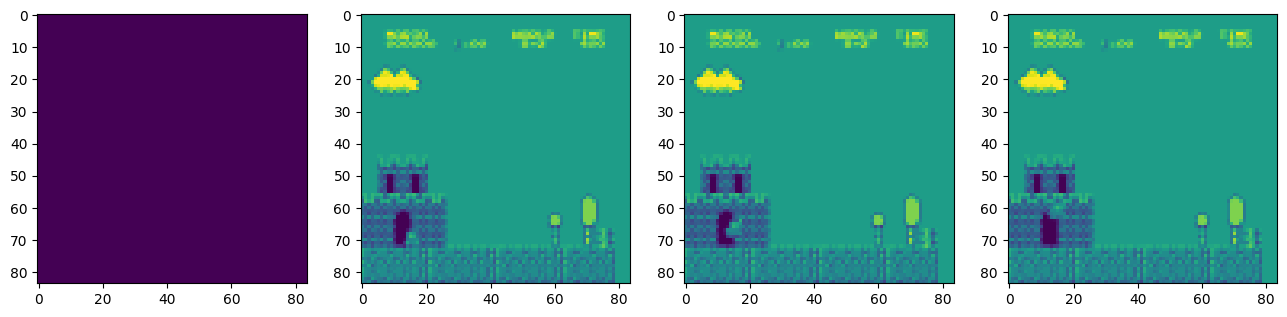

In [ ]:
state, reward, done, info = env.step([2])
display_all_frame()

In [ ]:
# Extract the second channel (index 1) from the first frame of the state
state[0][:,:,1]

array([[140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       ...,
       [154, 124, 123, ...,  84, 153,  83],
       [123,  93,  80, ..., 112, 124,  83],
       [116, 103, 122, ..., 113,  83,  55]], dtype=uint8)

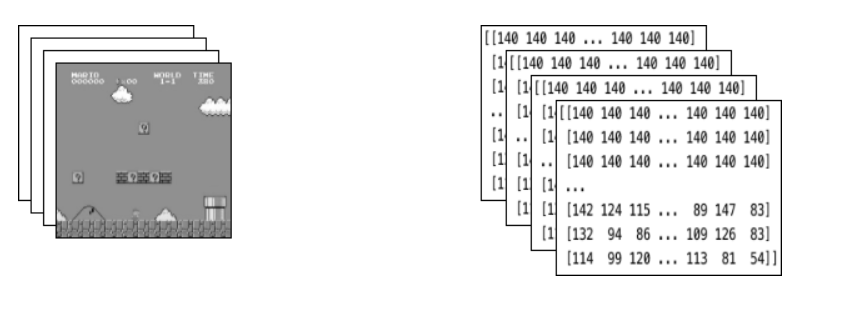

## 6. Train the AI Model

`Note:` If you prefer not to load a pre-trained model and wish to train a new one, please proceed to the next step. You can stop this learning process once you have a good model and move on to the next one.

In [ ]:
# Directory for trained model
CHECKPOINT_DIR = './train/'

# Directory for log files
LOG_DIR = './logs/'

# Filename for reward log
REWARD_LOG_FILENAME = 'reward_log.csv'

In [ ]:
with open(REWARD_LOG_FILENAME, 'a') as f:
    print('timesteps,reward,best_reward', file=f)

In [ ]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = (CHECKPOINT_DIR / 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                while not done and total_time[i] < MAX_TIMESTEP_TEST:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                if total_reward[i] > best_reward:
                    best_reward = total_reward[i]
                    best_epoch = self.n_calls

                state = env.reset()  # reset for each new trial

            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward)

            with open(REWARD_LOG_FILENAME, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, ',', best_reward, file=f)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq=CHECK_FREQ_NUMB, save_path=CHECKPOINT_DIR)

In [ ]:
model = PPO('CnnPolicy', env, verbose=0, tensorboard_log=LOG_DIR, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
              batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA, gae_lambda=GAE, ent_coef=ENT_COEF)

In [ ]:
%%time
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB, callback=callback)

## 7. Test the AI model

**Reference:** https://safjan.com/download-data-google-drive-colab-gdown/


In [ ]:
import gdown
file_id = "1-v_YD4OKEhJqUGwCPFaAQchaeIU8RDb1"
output_file = "Mario_AI_8_2.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1-v_YD4OKEhJqUGwCPFaAQchaeIU8RDb1
To: /content/Mario_AI_8_2.zip
100%|██████████| 20.4M/20.4M [00:00<00:00, 119MB/s]


'Mario_AI_8_2.zip'

In [ ]:
# Load the model
model = PPO.load('Mario_AI_8_2.zip')

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/base_class.py:728: UserWarning: You are probably loading a model saved with SB3 < 1.7.0, we deactivated exact_match so you can save the model again to avoid issues in the future (see https://github.com/DLR-RM/stable-baselines3/issues/1233 for more info). Original error: Error(s) in loading state_dict for ActorCriticCnnPolicy:
	Missing key(s) in state_dict: "pi_features_

`Note:`

- If it says `'<<< Mario got the flag. GOAL! >>>`, you have likely cleared the level successfully.

- If you receive a low reward, `consider trying again several times for better results.`

- If you do not achieve a high reward, you may have failed to clear the level.

In [ ]:
EPISODE_NUMBERS = 100
MAX_TIMESTEP_TEST = 1000

In [ ]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0
    total_time[i] = 0
    frames = []
    while not done and total_time[i] < MAX_TIMESTEP_TEST:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        total_reward[i] += reward[0]
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

    # Judgement Mario goal or not
    if info[0]['flag_get']:
        print(f"<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>")
        break

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

test episode: 0 reward: 738.1999848112464 time: 230
test episode: 1 reward: 851.9999827817082 time: 273
test episode: 2 reward: 941.599981367588 time: 423
test episode: 3 reward: 737.8999849185348 time: 229
test episode: 4 reward: 872.3999824821949 time: 284
test episode: 5 reward: 901.0999814942479 time: 294
test episode: 6 reward: 254.6999957188964 time: 94
test episode: 7 reward: 844.1999828889966 time: 269
test episode: 8 reward: 872.2999825328588 time: 274
test episode: 9 reward: 900.3999825641513 time: 328
test episode: 10 reward: 737.8999848365784 time: 226
test episode: 11 reward: 422.29999216645956 time: 142
test episode: 12 reward: 737.8999849185348 time: 227
test episode: 13 reward: 770.2999845966697 time: 287
test episode: 14 reward: 823.099983908236 time: 274
test episode: 15 reward: 870.2999824732542 time: 273
GOAL
test episode: 16 reward: 1028.099978968501 time: 340
<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>
average reward: 133.04699733428657 average time: 44.

In [ ]:
SKIP_RATE = 1

In [ ]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Generate a video that can be viewed on Google Colab. If you press the play button after generation, you can watch AI Mario's gameplay.

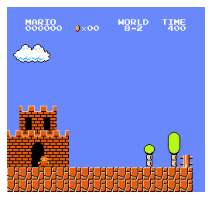

In [ ]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

## Generate GIF from AI Best Gameplay

Reference: https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent

In [ ]:
import imageio
imageio.mimsave('Mario_AI_8_2.gif', [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=29)

In [ ]:
from google.colab import files
files.download('Mario_AI_8_2.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

In this notebook, we have successfully created an Mario AI agent capable of clearing stage 8-2 in the Super Mario Bros game.

## References:
- https://github.com/nicknochnack/MarioRL
- https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
- https://github.com/YuansongFeng/MadMario
- https://youtu.be/dWmJ5CXSKdw?si=pjU2bHCGA_zMel5h